In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from s3fs import S3FileSystem, S3Map
from scipy import signal

from myspectra import filt_decompose

In [2]:
plt.rcParams['font.size']=14
plt.rcParams['axes.labelsize']='large'
plt.rcParams['pcolor.shading']='auto'

In [137]:
# EAC site
# ncfile = 'imos-data/IMOS/DWM/DA/EAC4700/Velocity/IMOS_DWM-DA_AETVZ_20190916T083300Z_EAC4700_FV01_EAC4700-2021-Aquadopp-Current-Meter-985_END-20210517T212700Z_C-20211208T224818Z.nc'
# # Plotting
# t1,t2 = np.datetime64('2020-09-01'), np.datetime64('2020-11-01')
# # Spectral estimation
# t1s, t2s = '2019-10-01','2021-05-01'
# sitename = 'EAC_1000m'

# # Southern Ocean
ncfile = 'imos-data/IMOS/DWM/SOTS/2021/IMOS_DWM-SOTS_AETVZ_20210424_SAZ47_FV01_SAZ47-23-2021-Aquadopp-Current-Meter-AQD-9897-1200m_END-_C-20220530.nc'
# Plotting
t1,t2 = np.datetime64('2021-09-01'), np.datetime64('2021-11-01')
# Spectral estimation
t1s, t2s = '2021-05-01','2022-05-01'
sitename = 'SO_1200m'

# Indonesian Throughflow
# ncfile = 'imos-data/IMOS/DWM/DA/ITFTSL/Velocity/IMOS_DWM-DA_ETVZ_20140410T020000Z_ITFTSL_FV01_ITFTSL-2014-AQUADOPP-CURRENT-METER-1189_END-20151025T225917Z_C-20160622T032641Z.nc'
# # Plotting
# t1,t2 = np.datetime64('2014-09-01'), np.datetime64('2014-11-01')
# # Spectral estimation
# t1s, t2s = '2014-05-01','2015-10-01'
# sitename = 'ITF_1200m'

#
ylims = -30, 30
velscale = 100. # Convert to cm

In [138]:
   
def open_file_nocache(fname, myfs):
    """
    Load a netcdf file directly from an S3 bucket
    """
    fileobj = myfs.open(fname)
    return xr.open_dataset(fileobj)

def get_vel_qc_aodn(ds,varname='UCUR'):
    """
    Function that returns the QC's variable
    (only works with FV01 of the IMOS convention)
    """
    badidx = ds['{}_quality_control'.format(varname)].values <2
    temp = ds['{}'.format(varname)]
    return temp.where(badidx, np.nan)


# Login to the s3 bucket and list the deep water mooring (DWM) folders
fs = S3FileSystem(anon=True)
    
ds = open_file_nocache(ncfile, fs)

# Load velocity
u = get_vel_qc_aodn(ds, varname='UCUR')
v = get_vel_qc_aodn(ds, varname='VCUR')

# Work out the sampling rate (seconds)
dt = (u.TIME[2]-u.TIME[1]).values.astype('float')/1e9
dt_days = dt/86400.

# Decompose the velocity into sub-tidal, tidal, and super-tidal by filtering
utmp = u.values*velscale
utmp[np.isnan(utmp)] = 0.
uf = filt_decompose(utmp, dt,low=60)

utmp = v.values*velscale
utmp[np.isnan(utmp)] = 0.
vf = filt_decompose(utmp, dt,low=60)

In [139]:
#install sfoda using:
#!pip install git+https://github.com/mrayson/sfoda.git@nogdal_nocython

from sfoda.utils.timeseries import timeseries

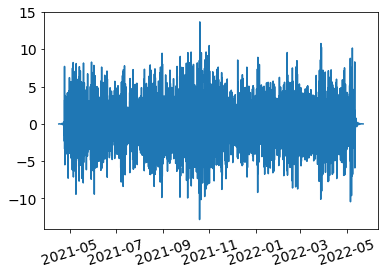

In [140]:
v_tidal = timeseries(u.TIME.values, vf[:,1])
plt.figure()
v_tidal.plot()

In [141]:
amp, phs, frq, mean, yfit, yrms = v_tidal.tidefit(frqnames=['M2','S2','N2','K1','O1','P1'])
print(1-yrms**2/v_tidal.y.var())

0.06630399276089982


/home/jupyter-ubuntu/.local/lib/python3.7/site-packages/sfoda/utils/harmonic_analysis.py:139: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,y)


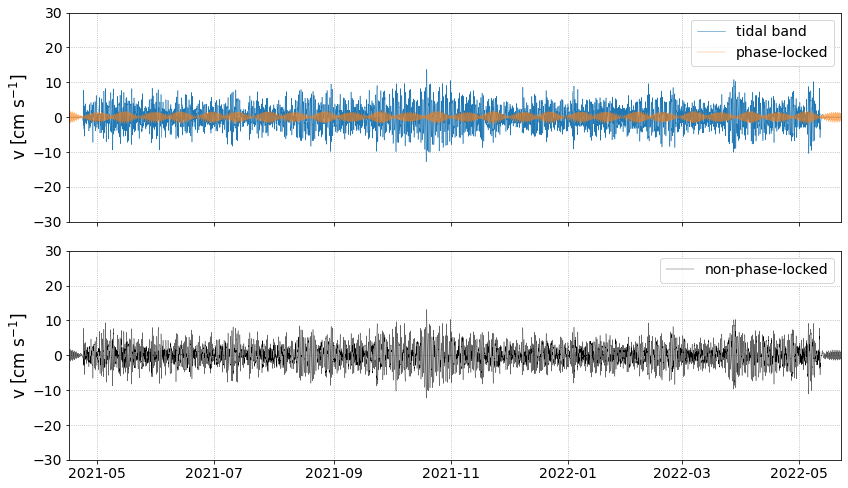

In [142]:
plt.figure(figsize=(12,7))

ax=plt.subplot(211)
v_tidal.plot(lw=0.5)
plt.plot(v_tidal.t, yfit, lw=0.3)

plt.ylim(ylims)
plt.xlim(v_tidal.t[0],v_tidal.t[-1])
plt.title('')
plt.ylabel('v [cm s$^{-1}$]')
ax.set_xticklabels([])
plt.grid(b=True, ls=':')
plt.xlabel('')
plt.legend(('tidal band', 'phase-locked'))

ax=plt.subplot(212)
plt.plot(v_tidal.t, v_tidal.y - yfit, 'k', lw=0.3)
plt.legend(('non-phase-locked',))

plt.ylim(ylims)
plt.xlim(v_tidal.t[0],v_tidal.t[-1])
plt.title('')
plt.ylabel('v [cm s$^{-1}$]')
# ax.set_xticklabels([])
plt.grid(b=True, ls=':')
plt.xlabel('')
plt.tight_layout()
plt.savefig('../FIGURES/Tidal_v_{}.png'.format(sitename), dpi=150)

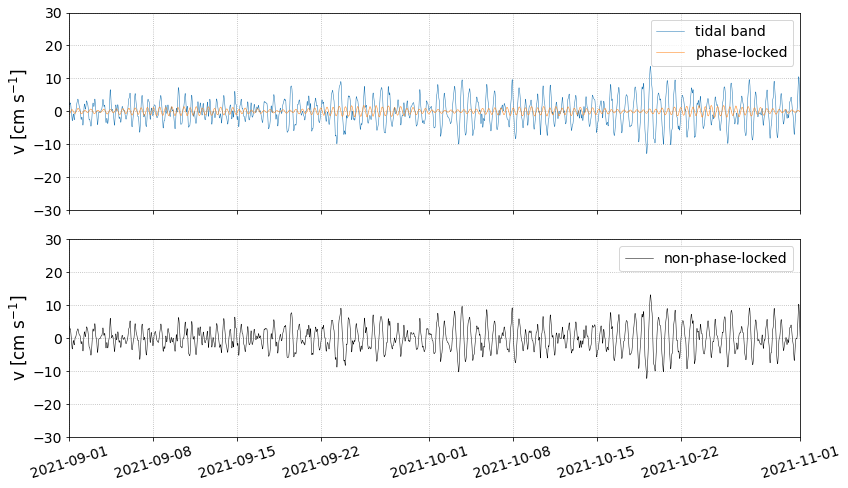

In [143]:
plt.figure(figsize=(12,7))

ax=plt.subplot(211)
v_tidal.plot(lw=0.5)
plt.plot(v_tidal.t, yfit, lw=0.5)

plt.ylim(ylims)
plt.xlim(v_tidal.t[0],v_tidal.t[-1])
plt.title('')
plt.ylabel('v [cm s$^{-1}$]')
ax.set_xticklabels([])
plt.grid(b=True, ls=':')
plt.xlabel('')
plt.legend(('tidal band', 'phase-locked'))
plt.xlim(t1,t2)

ax=plt.subplot(212)
plt.plot(v_tidal.t, v_tidal.y - yfit, 'k', lw=0.5)
plt.legend(('non-phase-locked',))

plt.ylim(ylims)
plt.xlim(v_tidal.t[0],v_tidal.t[-1])
plt.title('')
plt.ylabel('v [cm s$^{-1}$]')
# ax.set_xticklabels([])
plt.grid(b=True, ls=':')
plt.xlabel('')
plt.xlim(t1,t2)
plt.xticks(rotation=17)
plt.tight_layout()
plt.savefig('../FIGURES/Tidal_v_zoom_{}.png'.format(sitename), dpi=150)

In [144]:
from statsmodels.tsa import stattools

def quadexpcos(tau, params):
    eta, lt, omega0 = params
    b = 1/lt
    return eta**2 * np.exp(-(tau*b)**2) * np.cos(omega0 * tau)

def expcos(tau, params):
    eta, lt, omega0 = params
    b=1/(lt)
    
    return eta**2 * np.exp(-tau*b) * np.cos(omega0 * tau)

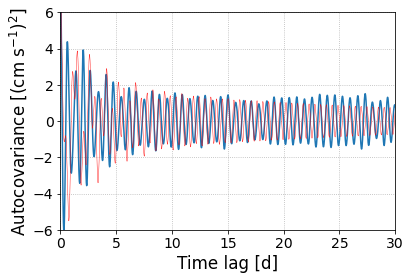

In [161]:
ndays=30.0

# tau = np.arange(0.,ndays+1/24.,1/24.)
tau = np.linspace(0.,ndays, int(1/dt_days*ndays+1))

acov = stattools.acovf( v_tidal.y- yfit , nlag=int(1/dt_days*ndays))
ymax = np.abs(acov).max()
                       
plt.figure()
plt.plot(tau, acov, ms=5)

plt.ylabel('Autocovariance [(cm s$^{-1}$)$^2$]')
plt.xlabel('Time lag [d]')

# plt.plot(tau, quadexpcos(tau, (np.sqrt(8), 2, 0*2*np.pi)) , c='b', ls='--')
# plt.plot(tau, -quadexpcos(tau, (np.sqrt(8), 2, 0*2*np.pi)) , c='b', ls='--')

# plt.plot(tau, quadexpcos(tau, (np.sqrt(4), 19, 0*2*np.pi)) , c='b', ls='--')
# plt.plot(tau, -quadexpcos(tau, (np.sqrt(4), 19, 0*2*np.pi)) , c='b', ls='--')

# ITF
# plt.plot(tau, expcos(tau, (np.sqrt(1.1), 30, 1.93*2*np.pi)) +
#          expcos(tau, (np.sqrt(1), 30, 2*np.pi)) +
#          expcos(tau, (np.sqrt(0.5), 30, 1.0*np.pi))
#          , c='r', ls='-',lw=0.4)

plt.plot(tau, expcos(tau, (np.sqrt(2), 30, 1.93*2*np.pi)) +
         expcos(tau, (np.sqrt(5), 3, 1.48*np.pi)) 
         , c='r', ls='-',lw=0.4)

# plt.plot(tau, -expcos(tau, (np.sqrt(5), 15, 0*2*np.pi)) , c='b', ls='--')
plt.xlim(0, ndays)
plt.ylim(-ymax-1, ymax+1)
plt.ylim(-6,6)
plt.grid(b=True, ls=':')
plt.savefig('../FIGURES/acovf_v_{}.png'.format(sitename), dpi=150)

In [121]:
24/12.42

1.932367149758454